Loading embeddings from embeddings_100.pt


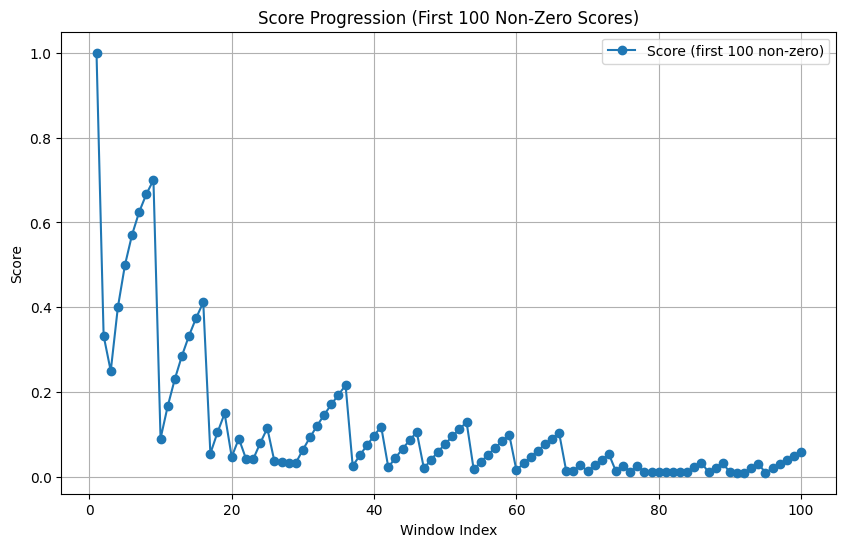

None


In [14]:
import json
import torch
from torch.utils.data import Dataset
from typing import Optional, Dict, Any, List
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
class RouterDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
        size: Optional[int] = None,
        data_type: str = "multi_attempt",
        dataset_id: int = 0,
        window_size: int = 3,  # 滑动窗口大小
        similarity_threshold: float = 0.95,  # 相似度阈值
        embedding_model_name: str = 'microsoft/mdeberta-v3-base',
        embedding_cache_path: str = 'embeddings_100.pt',
    ):
        """
        A PyTorch Dataset for routing questions with similarity-based sliding window support using DeBERTa-v3.

        Args:
            data_path (str): Path to the JSON data file.
            source_max_token_len (int, optional): Maximum token length for the source. Defaults to 512.
            target_max_token_len (int, optional): Maximum token length for the target. Defaults to 512.
            size (Optional[int], optional): Desired size of the dataset. If provided, the data is repeated to reach this size. Defaults to None.
            data_type (str, optional): Type of data. Defaults to "multi_attempt".
            dataset_id (int, optional): Identifier for the dataset. Defaults to 0.
            window_size (int, optional): Sliding window size. Defaults to 3.
            similarity_threshold (float, optional): Threshold for similarity to consider as the same dialogue round. Defaults to 0.7.
            embedding_model_name (str, optional): Hugging Face model name for embedding. Defaults to 'microsoft/mdeberta-v3-base'.
            device (str, optional): Device to run the embedding model on ('cpu' or 'cuda'). Defaults to 'cpu'.
            embedding_cache_path (str, optional): Path to cache embeddings. Defaults to 'embeddings.pt'.
        """
        self.data_path = data_path
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len
        
        self.data_type = data_type
        self.dataset_id = dataset_id
        self.window_size = window_size
        self.similarity_threshold = similarity_threshold
        self.embedding_model_name = embedding_model_name
        self.device = "cuda:1"
        self.embedding_cache_path = embedding_cache_path

        # 加载数据
        self.data = self.load_data(self.data_path)  #可以不变
        self.size=len(self.data)
        # 初始化分词器
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.embedding_model_name,
            truncation_side='left',
            padding=True
        )

        # 初始化嵌入模型
        self.embedding_model = AutoModel.from_pretrained(self.embedding_model_name).to(self.device)
        self.embedding_model.eval()  # 设置为评估模式
        self.router_node="gpt"  #这里要修改一下，eval是没有的
        # 计算或加载嵌入
        self.embeddings = self.load_or_compute_embeddings()

        # 预处理数据为相似度划分的滑动窗口形式
        self.processed_data = self.generate_expanding_windows_from_round(self.data,window_size=self.window_size)

    def load_data(self, data_path) :
        """
        加载JSON格式的数据文件。

        Args:
            data_path (str): 数据文件路径。

        Returns:
            List[Dict[str, Any]]: 加载的数据列表。
        """
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data file not found at {data_path}")

        with open(data_path, 'r', encoding='utf-8') as f:
            if data_path.endswith('.json'):
                try:
                    data = json.load(f)
                    data=data[:100]
                except json.JSONDecodeError as e:
                    raise ValueError(f"Error decoding JSON from {data_path}: {e}")
            else:
                raise ValueError("Unsupported file format. Only JSON files are supported.")
            result = []

        for item in data:
    # 保留偶数位置的对话（索引为 0, 2, 4...）
            filtered_conversations = [entry['value'] for idx, entry in enumerate(item['conversations']) if idx % 2 == 0]
    # 保存到结果中           
            for full_conversation in filtered_conversations:
                result.append({'id': item['id'], 'conversation': full_conversation} )
        return result #遇到continue这样的相关性其实就一般了
    def load_or_compute_embeddings(self):
        """
        加载嵌入缓存，如果不存在则计算嵌入并缓存。
        """
        if os.path.exists(self.embedding_cache_path):
            print(f"Loading embeddings from {self.embedding_cache_path}")
            embeddings = torch.load(self.embedding_cache_path)
            if len(embeddings) != len(self.data):
                print("Embedding size mismatch. Recomputing embeddings.")
                embeddings = self.compute_embeddings([entry['conversation'] for entry in self.data],64)
                torch.save(embeddings, self.embedding_cache_path)
        else:
            print("Computing embeddings...")
            embeddings = self.compute_embeddings([entry['conversation']  for entry in self.data],batch_size=64) #要修改一下
            torch.save(embeddings, self.embedding_cache_path)
            print(f"Embeddings saved to {self.embedding_cache_path}")
        return embeddings

    def compute_embeddings(self, texts, batch_size) :
        """
        批量计算文本的嵌入。
        """
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc="Computing embeddings"):
                batch_texts = texts[i:i + batch_size]
                encoded_input = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=self.source_max_token_len,
                    return_tensors='pt'
                ).to(self.device)
                model_output = self.embedding_model(**encoded_input)
                # 平均池化所有 token 的隐藏状态
                attention_mask = encoded_input['attention_mask']
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.last_hidden_state.size()).float()
                sum_embeddings = torch.sum(model_output.last_hidden_state * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = sum_embeddings / sum_mask
                # 归一化嵌入以便于余弦相似度计算
                batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
                embeddings.extend(batch_embeddings.cpu())
        return embeddings

    def generate_windows_from_round(
        self, round_data, window_size
    ) :
        """
        从一个对话轮次中生成滑动窗口。
        """
        score=0
        single=False
        combined_id = round_data[-1]['id'] 
        if(len(round_data)==1):
            single=True #单个句子不参与打分，避免影响轮数的区分
        else:
            for item in round_data:
                if(item["id"]==combined_id):
                    score+=1
            score=score/(len(round_data))
        combined_question = " ".join([item['conversation'] for item in round_data]) #这里要修改一下                                    
        windows={
                'id': combined_id,
                'conversation': combined_question,
                'score':score,
                'single':single,
            }
        return windows
    def generate_expanding_windows_from_round(
        self, round_data, window_size
    ):
        windows = []
    # 生成扩展窗口：逐渐增大窗口大小，直到达到 window_size 后保持不变
        for i in range(1, len(round_data)-window_size+ 1):
            window_data = round_data[:i]  # 窗口大小从1到i逐渐增大
            combined_id = window_data[-1]['id']
            score = 0
            single = False

        # 如果是单个句子，标记为单句，避免影响评分
            if len(window_data) == 1:
                single = True
            else:
                for item in window_data:
                    if item["id"] == combined_id:
                        score += 1
                score = score / len(window_data)  # 计算得分，得分为该句子的相似度

        # 合并窗口中的所有对话
            window_conversation = " ".join([item['conversation'] for item in window_data])

        # 生成窗口数据
            windows.append({
            'id': combined_id,
            'conversation': window_conversation,
            'score': score,
            'single': single,
            })
    
        return windows
    def eval(self):
        accuray=0
        single=0
        for item in self.processed_data:
            if(item['single']):
                single+=1
            else:
                accuray+=item['score']
        if(single==len(self.processed_data)):
            return 1
        accuray/=(len(self.processed_data)-single)     
        return accuray
    def __getitem__(self, index):
        data_point = self.processed_data[index]
        scores = torch.tensor(list(data_point['scores'].values()))
        question = data_point['question']
        question_id = self.tokenizer(
            question,
            max_length=self.target_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )
        question_id['input_ids'] = question_id.input_ids.flatten()
        question_id['attention_mask'] = question_id.attention_mask.flatten()
        cluster_id = data_point['cluster_id'] if "cluster_id" in data_point else 0
        return question_id, scores, self.dataset_id, cluster_id
    
    def __len__(self) -> int:
        """
        Returns the total number of samples.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.processed_data)

    def register_tokenizer(self, tokenizer: Any):
        """
        Registers a tokenizer for the dataset.

        Args:
            tokenizer (Any): Tokenizer instance.
        """
        self.tokenizer = tokenizer
    def plot_scores_from_processed_data(self, max_points=100):
        """
    绘制非零的score曲线，并限制最多绘制max_points个数据点。

    Args:
        max_points (int): 最大绘制点数，默认100。
        """
    # 提取非零的score，限制最多绘制max_points个点
        scores = []
        indices = []
        count = 0

        for i, item in enumerate(self.processed_data):
            if 'score' in item and item['score'] > 0:
                scores.append(item['score'])
                indices.append(i)
                count += 1
                if count >= max_points:
                    break


        plt.figure(figsize=(10, 6))
        plt.plot(indices, scores, marker='o', label=f'Score (first {max_points} non-zero)')
        plt.title(f'Score Progression (First {max_points} Non-Zero Scores)')
        plt.xlabel('Window Index')
        plt.ylabel('Score')
        plt.legend()
        plt.grid()
        plt.show()


# 打开 JSON 文件
file_path = "sharegpt_20230401_clean_lang_split.json"

with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 查看文件的部分内容
# 检查数据类型 (通常是dict或list) dict:len(data)=126032 

router_dataset = RouterDataset(
        file_path,
        size=len(data),
        data_type="multiple",
        dataset_id=0,
        window_size=3 ,
        similarity_threshold=0.99
    )

print(router_dataset.plot_scores_from_processed_data())


Loading embeddings from embeddings_1000.pt


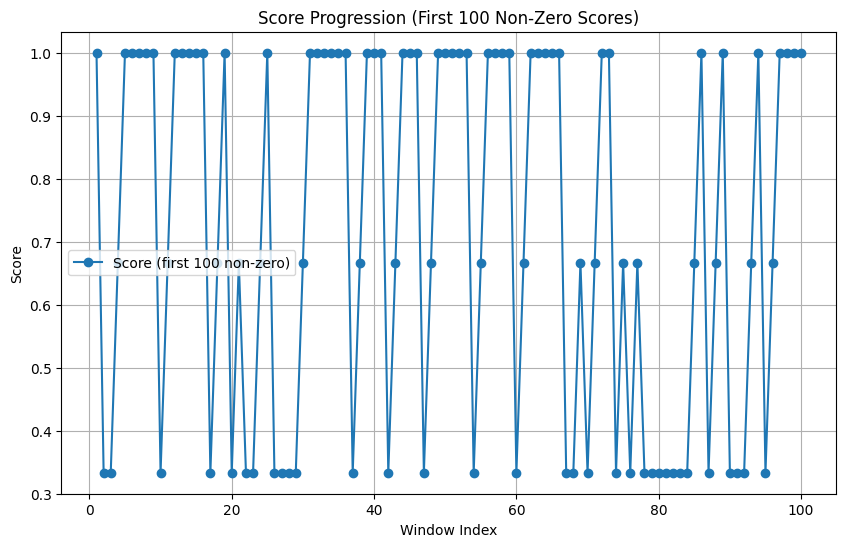

None


In [19]:
import json
import torch
from torch.utils.data import Dataset
from typing import Optional, Dict, Any, List
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
class RouterDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
        size: Optional[int] = None,
        data_type: str = "multi_attempt",
        dataset_id: int = 0,
        window_size: int = 3,  # 滑动窗口大小
        similarity_threshold: float = 0.95,  # 相似度阈值
        embedding_model_name: str = 'microsoft/mdeberta-v3-base',
        embedding_cache_path: str = 'embeddings_1000.pt',
    ):
        """
        A PyTorch Dataset for routing questions with similarity-based sliding window support using DeBERTa-v3.

        Args:
            data_path (str): Path to the JSON data file.
            source_max_token_len (int, optional): Maximum token length for the source. Defaults to 512.
            target_max_token_len (int, optional): Maximum token length for the target. Defaults to 512.
            size (Optional[int], optional): Desired size of the dataset. If provided, the data is repeated to reach this size. Defaults to None.
            data_type (str, optional): Type of data. Defaults to "multi_attempt".
            dataset_id (int, optional): Identifier for the dataset. Defaults to 0.
            window_size (int, optional): Sliding window size. Defaults to 3.
            similarity_threshold (float, optional): Threshold for similarity to consider as the same dialogue round. Defaults to 0.7.
            embedding_model_name (str, optional): Hugging Face model name for embedding. Defaults to 'microsoft/mdeberta-v3-base'.
            device (str, optional): Device to run the embedding model on ('cpu' or 'cuda'). Defaults to 'cpu'.
            embedding_cache_path (str, optional): Path to cache embeddings. Defaults to 'embeddings.pt'.
        """
        self.data_path = data_path
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len
        
        self.data_type = data_type
        self.dataset_id = dataset_id
        self.window_size = window_size
        self.similarity_threshold = similarity_threshold
        self.embedding_model_name = embedding_model_name
        self.device = "cuda:1"
        self.embedding_cache_path = embedding_cache_path

        # 加载数据
        self.data = self.load_data(self.data_path)  #可以不变
        self.size=len(self.data)
        # 初始化分词器
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.embedding_model_name,
            truncation_side='left',
            padding=True
        )

        # 初始化嵌入模型
        self.embedding_model = AutoModel.from_pretrained(self.embedding_model_name).to(self.device)
        self.embedding_model.eval()  # 设置为评估模式
        self.router_node="gpt"  #这里要修改一下，eval是没有的
        # 计算或加载嵌入
        self.embeddings = self.load_or_compute_embeddings()

        # 预处理数据为相似度划分的滑动窗口形式
        self.processed_data = self.generate_expanding_windows_from_round(self.data,window_size=self.window_size)

    def load_data(self, data_path) :
        """
        加载JSON格式的数据文件。

        Args:
            data_path (str): 数据文件路径。

        Returns:
            List[Dict[str, Any]]: 加载的数据列表。
        """
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data file not found at {data_path}")

        with open(data_path, 'r', encoding='utf-8') as f:
            if data_path.endswith('.json'):
                try:
                    data = json.load(f)
                    data=data[:1000]
                except json.JSONDecodeError as e:
                    raise ValueError(f"Error decoding JSON from {data_path}: {e}")
            else:
                raise ValueError("Unsupported file format. Only JSON files are supported.")
            result = []

        for item in data:
    # 保留偶数位置的对话（索引为 0, 2, 4...）
            filtered_conversations = [entry['value'] for idx, entry in enumerate(item['conversations']) if idx % 2 == 0]
    # 保存到结果中           
            for full_conversation in filtered_conversations:
                result.append({'id': item['id'], 'conversation': full_conversation} )
        return result #遇到continue这样的相关性其实就一般了
    def load_or_compute_embeddings(self):
        """
        加载嵌入缓存，如果不存在则计算嵌入并缓存。
        """
        if os.path.exists(self.embedding_cache_path):
            print(f"Loading embeddings from {self.embedding_cache_path}")
            embeddings = torch.load(self.embedding_cache_path)
            if len(embeddings) != len(self.data):
                print("Embedding size mismatch. Recomputing embeddings.")
                embeddings = self.compute_embeddings([entry['question'] for entry in self.data],64)
                torch.save(embeddings, self.embedding_cache_path)
        else:
            print("Computing embeddings...")
            embeddings = self.compute_embeddings([entry['conversation']  for entry in self.data],batch_size=64) #要修改一下
            torch.save(embeddings, self.embedding_cache_path)
            print(f"Embeddings saved to {self.embedding_cache_path}")
        return embeddings

    def compute_embeddings(self, texts, batch_size) :
        """
        批量计算文本的嵌入。
        """
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc="Computing embeddings"):
                batch_texts = texts[i:i + batch_size]
                encoded_input = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=self.source_max_token_len,
                    return_tensors='pt'
                ).to(self.device)
                model_output = self.embedding_model(**encoded_input)
                # 平均池化所有 token 的隐藏状态
                attention_mask = encoded_input['attention_mask']
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.last_hidden_state.size()).float()
                sum_embeddings = torch.sum(model_output.last_hidden_state * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = sum_embeddings / sum_mask
                # 归一化嵌入以便于余弦相似度计算
                batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
                embeddings.extend(batch_embeddings.cpu())
        return embeddings

    def generate_windows_from_round(
        self, round_data, window_size
    ) :
        """
        从一个对话轮次中生成滑动窗口。
        """
        score=0
        single=False
        combined_id = round_data[-1]['id'] 
        if(len(round_data)==1):
            single=True #单个句子不参与打分，避免影响轮数的区分
        else:
            for item in round_data:
                if(item["id"]==combined_id):
                    score+=1
            score=score/(len(round_data))
        combined_question = " ".join([item['conversation'] for item in round_data]) #这里要修改一下                                    
        windows={
                'id': combined_id,
                'conversation': combined_question,
                'score':score,
                'single':single,
            }
        return windows
    def generate_expanding_windows_from_round(self, round_data, window_size):
        """
    生成扩展窗口：逐渐增大窗口大小，直到达到 window_size 后保持不变。
    
    参数：
    - round_data: 每一轮的对话数据，应该是一个列表，包含多个对话项。
    - window_size: 窗口的最大大小。
    
    返回：
    - windows: 生成的滑动窗口列表，每个窗口包含 'id', 'conversation', 'score', 'single' 等信息。
        """
        windows = []

    # 滑动窗口从1逐渐增大到window_size
        for i in range(1, len(round_data)-window_size + 1):  # 从1到len(round_data)进行循环
            window_data = round_data[:i]  # 获取从开始到当前索引的数据作为窗口

        # 如果窗口大小已经达到window_size，窗口大小保持不变
            if len(window_data) > window_size:
                window_data = window_data[-window_size:]  # 保持窗口大小为window_size

            combined_id = window_data[-1]['id']  # 最后一个项的id用于合并窗口
            score = 0
            single = False

        # 如果是单个句子，标记为单句，避免影响评分
            if len(window_data) == 1:
                single = True
            else:
            # 遍历窗口中的每个元素，计算相似度得分
                for item in window_data:
                    if item["id"] == combined_id:
                        score += 1

            # 计算得分：得分为该句子的相似度，得分范围在0到1之间
                score = score / len(window_data)

            # 合并窗口中的所有对话
            window_conversation = " ".join([item['conversation'] for item in window_data])

            # 生成窗口数据
            windows.append({
            'id': combined_id,
            'conversation': window_conversation,
            'score': score,
            'single': single,
            })

        return windows

    def eval(self):
        accuray=0
        single=0
        for item in self.processed_data:
            if(item['single']):
                single+=1
            else:
                accuray+=item['score']
        if(single==len(self.processed_data)):
            return 1
        accuray/=(len(self.processed_data)-single)     
        return accuray
    def __getitem__(self, index):
        data_point = self.processed_data[index]
        scores = torch.tensor(list(data_point['scores'].values()))
        question = data_point['question']
        question_id = self.tokenizer(
            question,
            max_length=self.target_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )
        question_id['input_ids'] = question_id.input_ids.flatten()
        question_id['attention_mask'] = question_id.attention_mask.flatten()
        cluster_id = data_point['cluster_id'] if "cluster_id" in data_point else 0
        return question_id, scores, self.dataset_id, cluster_id
    
    def __len__(self) -> int:
        """
        Returns the total number of samples.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.processed_data)

    def register_tokenizer(self, tokenizer: Any):
        """
        Registers a tokenizer for the dataset.

        Args:
            tokenizer (Any): Tokenizer instance.
        """
        self.tokenizer = tokenizer
    def plot_scores_from_processed_data(self, max_points=100):
        """
    绘制非零的score曲线，并限制最多绘制max_points个数据点。

    Args:
        max_points (int): 最大绘制点数，默认100。
        """
    # 提取非零的score，限制最多绘制max_points个点
        scores = []
        indices = []
        count = 0

        for i, item in enumerate(self.processed_data):
            if 'score' in item and item['score'] > 0:
                scores.append(item['score'])
                indices.append(count+1)
                count += 1
                if count >= max_points:
                    break

        plt.figure(figsize=(10, 6))
        plt.plot(indices, scores, marker='o', label=f'Score (first {max_points} non-zero)')
        plt.title(f'Score Progression (First {max_points} Non-Zero Scores)')
        plt.xlabel('Window Index')
        plt.ylabel('Score')
        plt.legend()
        plt.grid()
        plt.show()
router_dataset = RouterDataset(
        file_path,
        size=len(data),
        data_type="multiple",
        dataset_id=0,
        window_size=3 ,
        similarity_threshold=0.99
    )

print(router_dataset.plot_scores_from_processed_data())

Computing embeddings...


Computing embeddings: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Embeddings saved to embeddings_200.pt


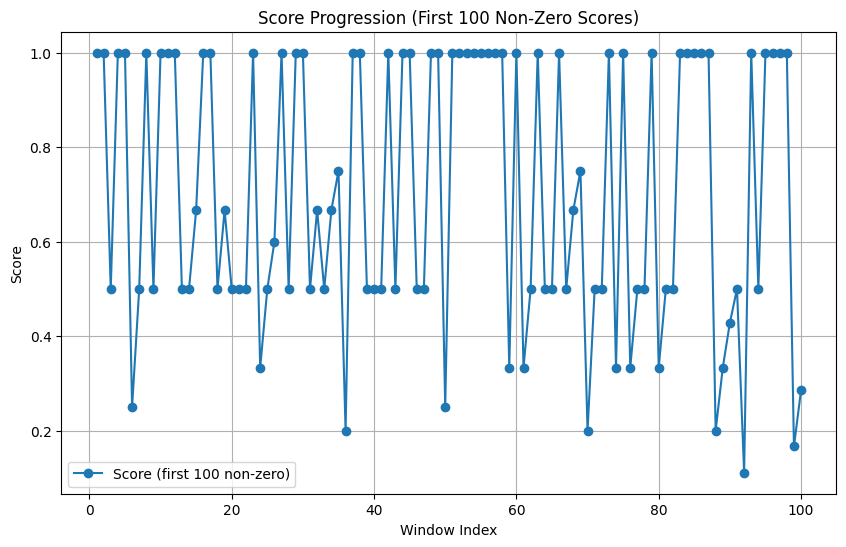

None


In [17]:
import json
import torch
from torch.utils.data import Dataset
from typing import Optional, Dict, Any, List
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
class RouterDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
        size: Optional[int] = None,
        data_type: str = "multi_attempt",
        dataset_id: int = 0,
        window_size: int = 3,  # 滑动窗口大小
        similarity_threshold: float = 0.95,  # 相似度阈值
        embedding_model_name: str = 'microsoft/mdeberta-v3-base',
        embedding_cache_path: str = 'embeddings_200.pt',
    ):
        """
        A PyTorch Dataset for routing questions with similarity-based sliding window support using DeBERTa-v3.

        Args:
            data_path (str): Path to the JSON data file.
            source_max_token_len (int, optional): Maximum token length for the source. Defaults to 512.
            target_max_token_len (int, optional): Maximum token length for the target. Defaults to 512.
            size (Optional[int], optional): Desired size of the dataset. If provided, the data is repeated to reach this size. Defaults to None.
            data_type (str, optional): Type of data. Defaults to "multi_attempt".
            dataset_id (int, optional): Identifier for the dataset. Defaults to 0.
            window_size (int, optional): Sliding window size. Defaults to 3.
            similarity_threshold (float, optional): Threshold for similarity to consider as the same dialogue round. Defaults to 0.7.
            embedding_model_name (str, optional): Hugging Face model name for embedding. Defaults to 'microsoft/mdeberta-v3-base'.
            device (str, optional): Device to run the embedding model on ('cpu' or 'cuda'). Defaults to 'cpu'.
            embedding_cache_path (str, optional): Path to cache embeddings. Defaults to 'embeddings.pt'.
        """
        self.data_path = data_path
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len
        
        self.data_type = data_type
        self.dataset_id = dataset_id
        self.window_size = window_size
        self.similarity_threshold = similarity_threshold
        self.embedding_model_name = embedding_model_name
        self.device = "cuda:1"
        self.embedding_cache_path = embedding_cache_path

        # 加载数据
        self.data = self.load_data(self.data_path)  #可以不变
        self.size=len(self.data)
        # 初始化分词器
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.embedding_model_name,
            truncation_side='left',
            padding=True
        )

        # 初始化嵌入模型
        self.embedding_model = AutoModel.from_pretrained(self.embedding_model_name).to(self.device)
        self.embedding_model.eval()  # 设置为评估模式
        self.router_node="gpt"  #这里要修改一下，eval是没有的
        # 计算或加载嵌入
        self.embeddings = self.load_or_compute_embeddings()

        # 预处理数据为相似度划分的滑动窗口形式
        self.processed_data = self.create_similarity_based_windows(
            self.data, self.window_size, self.similarity_threshold
        )

    def load_data(self, data_path) :
        """
        加载JSON格式的数据文件。

        Args:
            data_path (str): 数据文件路径。

        Returns:
            List[Dict[str, Any]]: 加载的数据列表。
        """
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data file not found at {data_path}")

        with open(data_path, 'r', encoding='utf-8') as f:
            if data_path.endswith('.json'):
                try:
                    data = json.load(f)
                    data=data[:200]
                except json.JSONDecodeError as e:
                    raise ValueError(f"Error decoding JSON from {data_path}: {e}")
            else:
                raise ValueError("Unsupported file format. Only JSON files are supported.")
            result = []

        for item in data:
    # 保留偶数位置的对话（索引为 0, 2, 4...）
            filtered_conversations = [entry['value'] for idx, entry in enumerate(item['conversations']) if idx % 2 == 0]
    # 保存到结果中           
            for full_conversation in filtered_conversations:
                result.append({'id': item['id'], 'conversation': full_conversation} )
        return result #遇到continue这样的相关性其实就一般了
    def load_or_compute_embeddings(self):
        """
        加载嵌入缓存，如果不存在则计算嵌入并缓存。
        """
        if os.path.exists(self.embedding_cache_path):
            print(f"Loading embeddings from {self.embedding_cache_path}")
            embeddings = torch.load(self.embedding_cache_path)
            if len(embeddings) != len(self.data):
                print("Embedding size mismatch. Recomputing embeddings.")
                embeddings = self.compute_embeddings([entry['question'] for entry in self.data],64)
                torch.save(embeddings, self.embedding_cache_path)
        else:
            print("Computing embeddings...")
            embeddings = self.compute_embeddings([entry['conversation']  for entry in self.data],batch_size=64) #要修改一下
            torch.save(embeddings, self.embedding_cache_path)
            print(f"Embeddings saved to {self.embedding_cache_path}")
        return embeddings

    def compute_embeddings(self, texts, batch_size) :
        """
        批量计算文本的嵌入。
        """
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc="Computing embeddings"):
                batch_texts = texts[i:i + batch_size]
                encoded_input = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=self.source_max_token_len,
                    return_tensors='pt'
                ).to(self.device)
                model_output = self.embedding_model(**encoded_input)
                # 平均池化所有 token 的隐藏状态
                attention_mask = encoded_input['attention_mask']
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.last_hidden_state.size()).float()
                sum_embeddings = torch.sum(model_output.last_hidden_state * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = sum_embeddings / sum_mask
                # 归一化嵌入以便于余弦相似度计算
                batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
                embeddings.extend(batch_embeddings.cpu())
        return embeddings

    def create_similarity_based_windows(
        self, data, window_size, threshold
    ) :
        """
        根据问题的相似度将数据划分为不同的对话轮次，并生成滑动窗口。
        Args:
            data (List[Dict[str, Any]]): 原始数据列表。
            window_size (int): 滑动窗口大小。
            threshold (float): 相似度阈值。
        """
        processed = []
        current_round = []
        previous_embedding = None

        for i, entry in enumerate(data):
            current_embedding = self.embeddings[i]

            if previous_embedding is not None:
                # 计算与前一个问题的余弦相似度
                cosine_sim = F.cosine_similarity(current_embedding, previous_embedding, dim=0).item()
                if cosine_sim >= threshold:
                    current_round.append(entry)
                else:
                    # 对当前轮次生成滑动窗口
                    # 开始新的轮次
                    current_round = [entry]
            else:
                current_round.append(entry)

            previous_embedding = current_embedding
            processed.append(self.generate_windows_from_round(current_round,window_size=10000))
        return processed

    def generate_windows_from_round(
        self, round_data, window_size
    ) :
        """
        从一个对话轮次中生成滑动窗口。
        """
        score=0
        single=False
        combined_id = round_data[-1]['id'] 
        if(len(round_data)==1):
            single=True #单个句子不参与打分，避免影响轮数的区分
        else:
            for item in round_data:
                if(item["id"]==combined_id):
                    score+=1
            score=score/(len(round_data))
        combined_question = " ".join([item['conversation'] for item in round_data]) #这里要修改一下                                    
        windows={
                'id': combined_id,
                'conversation': combined_question,
                'score':score,
                'single':single,
            }
        return windows
    def eval(self):
        accuray=0
        single=0
        for item in self.processed_data:
            if(item['single']):
                single+=1
            else:
                accuray+=item['score']
        if(single==len(self.processed_data)):
            return 1
        accuray/=(len(self.processed_data)-single)     
        return accuray
    def __getitem__(self, index):
        data_point = self.processed_data[index]
        scores = torch.tensor(list(data_point['scores'].values()))
        question = data_point['question']
        question_id = self.tokenizer(
            question,
            max_length=self.target_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )
        question_id['input_ids'] = question_id.input_ids.flatten()
        question_id['attention_mask'] = question_id.attention_mask.flatten()
        cluster_id = data_point['cluster_id'] if "cluster_id" in data_point else 0
        return question_id, scores, self.dataset_id, cluster_id
    def __len__(self) -> int:
        """
        Returns the total number of samples.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.processed_data)

    def register_tokenizer(self, tokenizer: Any):
        """
        Registers a tokenizer for the dataset.

        Args:
            tokenizer (Any): Tokenizer instance.
        """
        self.tokenizer = tokenizer
    def plot_scores_from_processed_data(self, max_points=100):
        """
    绘制非零的score曲线，并限制最多绘制max_points个数据点。

    Args:
        max_points (int): 最大绘制点数，默认100。
        """
    # 提取非零的score，限制最多绘制max_points个点
        scores = []
        indices = []
        count = 0

        for i, item in enumerate(self.processed_data):
            if 'score' in item and item['score'] > 0:
                scores.append(item['score'])
                indices.append(count+1)
                count += 1
                if count >= max_points:
                    break

        plt.figure(figsize=(10, 6))
        plt.plot(indices, scores, marker='o', label=f'Score (first {max_points} non-zero)')
        plt.title(f'Score Progression (First {max_points} Non-Zero Scores)')
        plt.xlabel('Window Index')
        plt.ylabel('Score')
        plt.legend()
        plt.grid()
        plt.show()
# 打开 JSON 文件
file_path = "sharegpt_20230401_clean_lang_split.json"

with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 查看文件的部分内容
# 检查数据类型 (通常是dict或list) dict:len(data)=126032 

router_dataset = RouterDataset(
        file_path,
        size=len(data),
        data_type="multiple",
        dataset_id=0,
        window_size=3 ,
        similarity_threshold=0.99
    )

print(router_dataset.plot_scores_from_processed_data())

